In [15]:
import os
import pandas as pd
import numpy as np

# not import for now since tf not working on mine Mac rn
#import tensorflow as tf

from calendar import month_name
# import seaborn as sns
from pandas.core.common import random_state
import tensorflow as tf

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm

from sklearn.metrics import balanced_accuracy_score

# from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from numpy import mean
from numpy import std
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel


from datetime import datetime
import math

from matplotlib import pyplot as plt

In [16]:
dirName_matchData = 'https://raw.githubusercontent.com/shabir-dhillon/GCW_0036/main/Group%20Coursework%20Brief-20221106/Data_Files/epl-full-training.csv'
dirName_rankingData = 'https://raw.githubusercontent.com/shabir-dhillon/GCW_0036/main/Group%20Coursework%20Brief-20221106/Data_Files/EPL%20Standings%202000-2022.csv'
dirName_managerData = 'https://raw.githubusercontent.com/shabir-dhillon/GCW_0036/main/Group%20Coursework%20Brief-20221106/Data_Files/epl-manager-data-V3.csv'

## Data Cleaning, Merging & Feature Engineering

In [17]:
# Read the main csv file
df_epl = pd.read_csv(dirName_matchData)
# Check the raw data
df_epl

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,17/08/2002,Blackburn,Sunderland,0,0,D,0,0,D,...,5,3,14,11,9,1,1,2,0,0
1,E0,17/08/2002,Charlton,Chelsea,2,3,A,2,1,H,...,5,12,10,12,3,6,0,3,1,0
2,E0,17/08/2002,Everton,Tottenham,2,2,D,1,0,H,...,9,5,18,4,10,5,1,1,0,0
3,E0,17/08/2002,Fulham,Bolton,4,1,H,3,1,H,...,6,1,16,12,7,4,1,2,0,0
4,E0,17/08/2002,Leeds,Man City,3,0,H,2,0,H,...,8,10,13,13,2,7,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,E0,06/11/2022,Chelsea,Arsenal,0,1,A,0,0,D,...,1,2,20,13,4,6,5,2,0,0
7732,E0,06/11/2022,Aston Villa,Man United,3,1,H,2,1,H,...,4,3,6,12,3,5,3,3,0,0
7733,E0,06/11/2022,Southampton,Newcastle,1,4,A,0,1,A,...,5,4,7,10,8,2,1,0,0,0
7734,E0,06/11/2022,West Ham,Crystal Palace,1,2,A,1,1,D,...,2,6,10,7,2,5,1,1,0,0


#### Encoding categorical data

In [18]:
# Transform the date column into day and month columns and Add into dataframe (Extract days & months from date)
# df_epl["Date"] = pd.to_datetime(df_epl["Date"])
df_epl["Date"] = pd.to_datetime(df_epl["Date"], dayfirst=True)
df_epl["Day"] = df_epl["Date"].dt.day
df_epl["Month"] = df_epl["Date"].dt.month 
df_epl["Year"] = df_epl["Date"].dt.year

# Turn the catergorical data into labels
df_epl["HomeTeam_Enc"] = df_epl["HomeTeam"].astype("category").cat.codes
df_epl["AwayTeam_Enc"] = df_epl["AwayTeam"].astype("category").cat.codes
df_epl["Referee_Enc"] = df_epl["Referee"].astype("category").cat.codes

FTR_encoder = LabelEncoder()
FTR_Enc = FTR_encoder.fit_transform(df_epl["FTR"])
df_epl["FTR_Enc"] = FTR_Enc
HTR_Enc = FTR_encoder.fit_transform(df_epl["HTR"])
df_epl["HTR_Enc"] = HTR_Enc

#### Adding Standings/Rankings Data To Dataframe

In [19]:
# Read the standings csv file
df_ranking = pd.read_csv(dirName_rankingData)

# PART 1 - HELPER FUNCTIONS:

def get_season_start_date(date):
    if int(date.month) <= 7:
      return datetime(int(date.year)-1, 8, 1)
    return datetime(int(date.year), 8, 1)



# PART 2 - ADDING STANDINGS DATA TO df_epl:

homeTeamRankings = []
awayTeamRankings = []
diffRankings = []

for index, row in df_epl.iterrows():
    season = get_season_start_date(row["Date"])
    prev_season = str(season.year-1) + "-" + str(season.year)[-2:] # from df_ranking
    homeTeam = row["HomeTeam"]    
    awayTeam = row["AwayTeam"]

    #filter dataframe ranking for year=season and hometeam=homeTeam
    df_epl_train_filtered_H = df_ranking.copy()
    df_epl_train_filtered_H = df_epl_train_filtered_H[(df_ranking.Season==prev_season) & (df_ranking.Team==homeTeam)]

    #filter dataframe ranking for year=season and awayTeam=awayTeam
    df_epl_train_filtered_A = df_ranking.copy()
    df_epl_train_filtered_A = df_epl_train_filtered_A[(df_ranking.Season==prev_season) & (df_ranking.Team==awayTeam)]
    
    # To keep df consistent, we add Nan to row, so we could remove it later by using df.dropna()
    # TODO: refactory
    # 18 represents team that been promoted from previous league this year. Hence, they don't have ranking from previous league
    # Pos is embbed inside pd.Series object, use values to access values of series.
    # Because Pos should be a int, hence, values always has length 1 or 0 (no data)
    if df_epl_train_filtered_H.empty and df_epl_train_filtered_A.empty:
        homeRanking = 18
        awayRanking = 18
    elif df_epl_train_filtered_H.empty and (not df_epl_train_filtered_A.empty):
        homeRanking = 18
        awayRanking = df_epl_train_filtered_A['Pos'].values[0]
    elif (not df_epl_train_filtered_H.empty) and df_epl_train_filtered_A.empty:
        homeRanking = df_epl_train_filtered_H['Pos'].values[0]
        awayRanking = 18
    else:
        homeRanking = df_epl_train_filtered_H['Pos'].values[0]
        awayRanking = df_epl_train_filtered_A['Pos'].values[0]

    homeTeamRankings.append(homeRanking)
    awayTeamRankings.append(awayRanking)
    diffRankings.append(homeRanking-awayRanking)

df_epl['HomeStanding_PrevSeason'] = homeTeamRankings
df_epl['AwayStanding_PrevSeason'] = awayTeamRankings
df_epl['DiffStanding_PrevSeason'] = diffRankings
df_epl

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,Month,Year,HomeTeam_Enc,AwayTeam_Enc,Referee_Enc,FTR_Enc,HTR_Enc,HomeStanding_PrevSeason,AwayStanding_PrevSeason,DiffStanding_PrevSeason
0,E0,2002-08-17,Blackburn,Sunderland,0,0,D,0,0,D,...,8,2002,3,34,12,1,1,10,17,-7
1,E0,2002-08-17,Charlton,Chelsea,2,3,A,2,1,H,...,8,2002,11,12,19,0,2,14,6,8
2,E0,2002-08-17,Everton,Tottenham,2,2,D,1,0,H,...,8,2002,15,36,43,1,2,15,9,6
3,E0,2002-08-17,Fulham,Bolton,4,1,H,3,1,H,...,8,2002,16,5,5,2,2,13,16,-3
4,E0,2002-08-17,Leeds,Man City,3,0,H,2,0,H,...,8,2002,19,22,20,2,2,5,18,-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,E0,2022-11-06,Chelsea,Arsenal,0,1,A,0,0,D,...,11,2022,12,0,39,0,1,3,5,-2
7732,E0,2022-11-06,Aston Villa,Man United,3,1,H,2,1,H,...,11,2022,1,23,4,2,2,14,6,8
7733,E0,2022-11-06,Southampton,Newcastle,1,4,A,0,1,A,...,11,2022,32,25,58,0,0,15,11,4
7734,E0,2022-11-06,West Ham,Crystal Palace,1,2,A,1,1,D,...,11,2022,39,13,50,0,1,7,12,-5


#### Adding Manager Data To Dataframe

In [20]:
# PART 1 - CLEAN MANAGER DATA:

# Check the original manager data - note nan's in 'End Date' indicate that manager is still at club
df_manager = pd.read_csv(dirName_managerData, encoding="ISO-8859-1")

# Here we update the nan values in the dataframe to the current date today
updatedEndDates = []
now = datetime.now() # Get current time
today = now.strftime("%d/%m/%Y")
for index, row in df_manager.iterrows():
    date =  row['End Date']
    if pd.isnull(date):
        updatedEndDates.append(today)
    else:
        updatedEndDates.append(date)
        
# Add these updated End_Dates to the dataframe
df_manager['End_Date'] = updatedEndDates

# Change the names of column index to include '_' instead of space and convert string dates into datetime objects
df_manager['Start_Date'] = pd.to_datetime(df_manager["Start Date"], dayfirst=True)
df_manager['End_Date'] = pd.to_datetime(df_manager["End_Date"], dayfirst=True)



# PART 2 - ADDING MANAGER DATA TO df_epl:

homeTeamManagers = []
awayTeamManagers = []

# Here for each row in the df_epl we will add the manager for home and away team
for index, row in df_epl.iterrows():
    date =  row['Date']
    homeTeam = row["HomeTeam"]
    awayTeam = row["AwayTeam"]

    #filter dataframe ranking for date between start and end of managers and hometeam=homeTeam
    df_epl_train_filtered_H = df_manager.copy()
    df_epl_train_filtered_H = df_epl_train_filtered_H[(df_manager.Start_Date<=date) & (df_manager.End_Date>=date) & (df_manager.Club==homeTeam)]

    #filter dataframe ranking for date between start and end of managers and awayTeam=awayTeam
    df_epl_train_filtered_A = df_manager.copy()
    df_epl_train_filtered_A = df_epl_train_filtered_A[(df_manager.Start_Date<=date) & (df_manager.End_Date>=date) & (df_manager.Club==awayTeam)]
    
    # NOTE - we get some managers as anonymous - this is happening when there is a change of manager (old manager has left, new manager has not started yet) and a match takes place
    if df_epl_train_filtered_H.empty:
        homeManager = "Anonymous"
    else:
        homeManager = df_epl_train_filtered_H['Name'].values[0]
        
    if df_epl_train_filtered_A.empty:
        awayManager = "Anonymous"
    else:
        awayManager = df_epl_train_filtered_A['Name'].values[0]
    
    homeTeamManagers.append(homeManager)
    awayTeamManagers.append(awayManager)

df_epl['Home_Manager'] = homeTeamManagers
df_epl['Away_Manager'] = awayTeamManagers
df_epl

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HomeTeam_Enc,AwayTeam_Enc,Referee_Enc,FTR_Enc,HTR_Enc,HomeStanding_PrevSeason,AwayStanding_PrevSeason,DiffStanding_PrevSeason,Home_Manager,Away_Manager
0,E0,2002-08-17,Blackburn,Sunderland,0,0,D,0,0,D,...,3,34,12,1,1,10,17,-7,Graeme Souness,Peter Reid
1,E0,2002-08-17,Charlton,Chelsea,2,3,A,2,1,H,...,11,12,19,0,2,14,6,8,Alan Curbishley,Claudio Ranieri
2,E0,2002-08-17,Everton,Tottenham,2,2,D,1,0,H,...,15,36,43,1,2,15,9,6,David Moyes,Glenn Hoddle
3,E0,2002-08-17,Fulham,Bolton,4,1,H,3,1,H,...,16,5,5,2,2,13,16,-3,Jean Tigana,Sam Allardyce
4,E0,2002-08-17,Leeds,Man City,3,0,H,2,0,H,...,19,22,20,2,2,5,18,-13,Terry Venables,Kevin Keegan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,E0,2022-11-06,Chelsea,Arsenal,0,1,A,0,0,D,...,12,0,39,0,1,3,5,-2,Graham Potter,Mikel Arteta
7732,E0,2022-11-06,Aston Villa,Man United,3,1,H,2,1,H,...,1,23,4,2,2,14,6,8,Unai Emery,Erik ten Hag
7733,E0,2022-11-06,Southampton,Newcastle,1,4,A,0,1,A,...,32,25,58,0,0,15,11,4,Ralph Hasenhüttl,Eddie Howe
7734,E0,2022-11-06,West Ham,Crystal Palace,1,2,A,1,1,D,...,39,13,50,0,1,7,12,-5,David Moyes,Patrick Vieira


#### Adding Average Past Match Statistics & Past Season % Number Of Wins - Feature Set 5

_HISTORY -> We add averages of past stats between the specific two teams in question. We obtain these stats (for each row of df_epl) by filtering the df_epl dataframe for matches ONLY between HomeTeam and AwayTeam that took place before the match date. Then take an average of the columns (with stats) like HR, AR, etc (of filtered dataframe). This happens for each row. This will provide us with the average past stats for games played in the past between the specific two teams.

_AVG -> We add averages of past stats between the for each of two teams in question. We obtain these stats (for each row of df_epl) by filtering the df_epl dataframe for matches between HomeTeam against ALL other teams that took place before the match date in that current season. Similar is done for the AwayTeam. Then take an average of the columns (with stats) like HR, AR, etc (of the filtered dataframe). This process happens for each row. This will provide us with the average past stats for the all HomeTeam games in that season and all AwayTeam games in that season.

HW_AVG & AW_AVG -> The number of past wins are calculated by summing the number of wins by the team in the season.

In [21]:
# PART 1 - THESE ARE HELPER FUNCTIONS WE NEED:

def get_season_start_date(date):
    if date.month <= 7:
        return datetime(date.year-1, 8, 1)
    return datetime(date.year-0, 8, 1)

def filter_dataframe_by_hometeam_history(df, date, HomeTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Date
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.HomeTeam_Enc==HomeTeam)]

    # Return filtered dataframe
    return df_filtered

def filter_dataframe_by_awayteam_history(df, date, AwayTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Date
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.AwayTeam_Enc==AwayTeam)]

    # Return filtered dataframe
    return df_filtered

def filter_dataframe_by_hometeam_recent_season(df, date, HomeTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Dateinput(first day of season) && HomeTeam=input(HomeTeam)
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.Date>get_season_start_date(date)) & (df_filtered.HomeTeam_Enc==HomeTeam)]

    # Return filtered dataframe
    return df_filtered

def filter_dataframe_by_awayteam_recent_season(df, date, AwayTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Dateinput(first day of season) && HomeTeam=input(HomeTeam)
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.Date>get_season_start_date(date)) & (df_filtered.AwayTeam_Enc==AwayTeam)]

    # Return filtered dataframe
    return df_filtered

# This function takes as input the filtered dataframe from previous cell, features to average and a dictionary,it then appends an average of each feature to the dictionary
def average_columns(avg_features, filtered_df):
    for feature in avg_features.keys():
        df_col_means = filtered_df[feature].mean()
        avg_features[feature].append(df_col_means)
        
# This function takes as input a filtered dataframe from previous cell, and a list, it then appends the % number of home/away wins in past
def find_number_of_wins(number_of_wins_list, filtered_df, team):
    df_filtered_ftr = filtered_df.copy()
    total_games = df_filtered_ftr.shape[0]
    if total_games == 0:
        number_of_wins_list.append(np.nan)
        return
    number_of_wins = df_filtered_ftr[(df_filtered_ftr.FTR==team)].shape[0]
    number_of_wins_list.append(number_of_wins/total_games)

        
# PART 2 - CREATE FEATURES & ADDING THEM TO DATAFRAME:

# These are the features we want to get averages for home team
avg_features_home_hist = {
                  "FTHG": [],
                  "HTHG": [],
                  "HS"  : [],
                  "HST" : [],
                  "HF"  : [],
                  "HC"  : [],
                  "HY"  : [],
                  "HR"  : []
              }

# These are the features we want to get averages for away team
avg_features_away_hist = {
                  "FTAG": [],
                  "HTAG": [],
                  "AS"  : [],
                  "AST" : [],
                  "AF"  : [],
                  "AC"  : [],
                  "AY"  : [],
                  "AR"  : []
                }

# These are the features we want to get averages for home team
avg_features_home_recent = {
                  "FTHG": [],
                  "HTHG": [],
                  "HS"  : [],
                  "HST" : [],
                  "HF"  : [],
                  "HC"  : [],
                  "HY"  : [],
                  "HR"  : []
              }

# These are the features we want to get averages for away team
avg_features_away_recent = {
                  "FTAG": [],
                  "HTAG": [],
                  "AS"  : [],
                  "AST" : [],
                  "AF"  : [],
                  "AC"  : [],
                  "AY"  : [],
                  "AR"  : []
                }

number_of_wins_HOME = []
number_of_wins_AWAY = []


# Run the two functions on each row of the df_epl and fill the dictionary
for index, row in df_epl.iterrows():
    # Filter the dataframe to only show matches played between those teams and before the certain date
    df_epl_train_average_hometeam_history = filter_dataframe_by_hometeam_history(df_epl, row["Date"],row["HomeTeam_Enc"])
    df_epl_train_average_awayteam_history = filter_dataframe_by_awayteam_history(df_epl, row["Date"],row["HomeTeam_Enc"])
    df_epl_train_average_hometeam_recent_season = filter_dataframe_by_hometeam_recent_season(df_epl, row["Date"],row["HomeTeam_Enc"])
    df_epl_train_average_awayteam_recent_season = filter_dataframe_by_awayteam_recent_season(df_epl, row["Date"],row["AwayTeam_Enc"])
    # Get averages from the filtered dataframe and add to the dictionary
    average_columns(avg_features_home_hist, df_epl_train_average_hometeam_history)
    average_columns(avg_features_away_hist, df_epl_train_average_awayteam_history)
    average_columns(avg_features_home_recent, df_epl_train_average_hometeam_recent_season)
    average_columns(avg_features_away_recent, df_epl_train_average_awayteam_recent_season)
    # Get number_of_wins from the filtered dataframe and add to list
    find_number_of_wins(number_of_wins_HOME, df_epl_train_average_hometeam_recent_season, "H")
    find_number_of_wins(number_of_wins_AWAY, df_epl_train_average_awayteam_recent_season, "A")

    
# Add features to dataframe
for feature in avg_features_home_hist.keys():
    # Get the list of averages for a certain feature from the dicitonary
    feature_vals = avg_features_home_hist[feature]
    # Add the list of averages into the dataframe for that certain feature
    df_epl[feature + "_HISTORY"] = feature_vals


# Add features to dataframe
for feature in avg_features_away_hist.keys():
    # Get the list of averages for a certain feature from the dicitonary
    feature_vals = avg_features_away_hist[feature]
    # Add the list of averages into the dataframe for that certain feature
    df_epl[feature + "_HISTORY"] = feature_vals


for feature in avg_features_home_recent.keys():
    # Get the list of averages for a certain feature from the dicitonary
    feature_vals = avg_features_home_recent[feature]
    # Add the list of averages into the dataframe for that certain feature
    df_epl[feature + "_AVG"] = feature_vals


for feature in avg_features_away_recent.keys():
    # Get the list of averages for a certain feature from the dicitonary
    feature_vals = avg_features_away_recent[feature]
    # Add the list of averages into the dataframe for that certain feature
    df_epl[feature + "_AVG"] = feature_vals
    
# Add the past % number of wins
df_epl["HW_AVG"] = number_of_wins_HOME
df_epl["AW_AVG"] = number_of_wins_AWAY


# Drop any rows with nan
df_epl = df_epl.dropna()
df_epl

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,FTAG_AVG,HTAG_AVG,AS_AVG,AST_AVG,AF_AVG,AC_AVG,AY_AVG,AR_AVG,HW_AVG,AW_AVG
20,E0,2002-08-27,Arsenal,West Brom,5,2,H,3,0,H,...,0.000000,0.000000,6.000000,5.000000,12.000000,1.000000,1.000000,1.0,1.000000,0.000000
21,E0,2002-08-27,Charlton,Tottenham,0,1,A,0,1,A,...,2.000000,0.000000,10.000000,5.000000,4.000000,5.000000,1.000000,0.0,0.000000,0.000000
22,E0,2002-08-28,Aston Villa,Man City,1,0,H,0,0,D,...,0.000000,0.000000,18.000000,10.000000,13.000000,7.000000,1.000000,0.0,0.000000,0.000000
23,E0,2002-08-28,Blackburn,Liverpool,2,2,D,1,1,D,...,1.000000,0.000000,12.000000,6.000000,5.000000,8.000000,2.000000,0.0,0.000000,1.000000
24,E0,2002-08-28,Everton,Birmingham,1,1,D,0,0,D,...,0.000000,0.000000,7.000000,1.000000,11.000000,2.000000,1.000000,1.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,E0,2022-11-06,Chelsea,Arsenal,0,1,A,0,0,D,...,1.833333,1.166667,12.333333,4.166667,9.833333,4.000000,1.833333,0.0,0.600000,0.666667
7732,E0,2022-11-06,Aston Villa,Man United,3,1,H,2,1,H,...,1.333333,0.500000,12.000000,5.000000,12.666667,2.833333,3.000000,0.0,0.500000,0.500000
7733,E0,2022-11-06,Southampton,Newcastle,1,4,A,0,1,A,...,1.333333,1.000000,11.833333,4.333333,9.000000,5.833333,1.500000,0.0,0.166667,0.333333
7734,E0,2022-11-06,West Ham,Crystal Palace,1,2,A,1,1,D,...,0.600000,0.600000,9.000000,3.400000,11.000000,2.800000,2.600000,0.0,0.500000,0.000000


#### Adding Expected Goals - Feature Set 6

The expected goals for each team are calculated using a polynomial regression classifier that is trained using  some of the average past statistics. Then for each row of df_epl, we predict the expected goals for HomeTeam and AwayTeam using the classifier.

In [22]:
# PART 1 - CREATE EXPECTED GOALS REGRESSION MODEL:

# Here we aim to create a 'expected or predicted goals for a HomeTeam' feature based upon past average stats
min_mse_home = float('inf')
min_mse_away = float('inf')

# Create the design matrix
X_H = df_epl.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'FTHG_AVG', 'HTHG_AVG', 'HS_AVG']].values
y_H = df_epl.loc[:,'FTHG'].values
X_H_train, X_H_test, y_H_train, y_H_test = model_selection.train_test_split(X_H, y_H, test_size=0.2, shuffle=False)

# Similar idea for AwayTeam
X_A = df_epl.loc[:,['Day', 'Month', 'AwayTeam_Enc', 'FTAG_AVG', 'HTAG_AVG', 'AS_AVG']].values
y_A = df_epl.loc[:,'FTAG'].values
X_A_train, X_A_test, y_A_train, y_A_test = model_selection.train_test_split(X_A, y_A, test_size=0.2, shuffle=False)

# Here we use a polynomial regression classifier - and select best order:
for i in range(1,5):
    # Select order
    poly = PolynomialFeatures(degree=i)

    # Transform the features
    X_H_train_transform = poly.fit_transform(X_H_train)
    X_H_test_transform = poly.fit_transform(X_H_test)

    LR_Model_HOME_EG = LinearRegression()
    # Fit the model using training data
    LR_Model_HOME_EG.fit(X_H_train_transform, y_H_train)
    # Make predictions using the model we have created
    LR_H_predictions_test = LR_Model_HOME_EG.predict(X_H_test_transform)
#     # Check the mean square error(MSE) for HomeTeam Expected Goals
#     print(i, mean_squared_error(LR_H_predictions_test, y_H_test))

    # Transform the features
    X_A_train_transform = poly.fit_transform(X_A_train)
    X_A_test_transform = poly.fit_transform(X_A_test)

    LR_Model_AWAY_EG = LinearRegression()
    # Fit the model using training data
    LR_Model_AWAY_EG.fit(X_A_train_transform, y_A_train)
    # Make predictions using the model we have created
    LR_A_predictions_test = LR_Model_AWAY_EG.predict(X_A_test_transform)
#     # Check the mean square error(MSE) for AwayTeam Expected Goals
#     print(i, mean_squared_error(LR_A_predictions_test, y_A_test))

    curr_mse_home = mean_squared_error(LR_H_predictions_test, y_H_test)
    curr_mse_away = mean_squared_error(LR_A_predictions_test, y_A_test)

    if curr_mse_home < min_mse_home:
        best_poly1 = poly
        best_model_home = LR_Model_HOME_EG
        min_mse_home = curr_mse_home

    if curr_mse_away < min_mse_away:
        best_poly2 = poly
        best_model_away = LR_Model_AWAY_EG
        min_mse_away = curr_mse_away
        
        
# PART 2 - ADD EXPECTED GOALS:

# Using the two regression classfiers above, predict the number of goals that the Home and Away teams will score for each row in the dataframe:
HomeExGoals = []
AwayExGoals = []

# For each row, predict the home and away expected goals
for index, row in df_epl.iterrows():
    X_Home_features = np.array([[row["Day"],row["Month"],row["HomeTeam_Enc"],row["FTHG_AVG"],row["HTHG_AVG"],row["HS_AVG"]]])
    X_Away_features = np.array([[row["Day"],row["Month"],row["AwayTeam_Enc"],row["FTAG_AVG"],row["HTAG_AVG"],row["AS_AVG"]]])
    # Transform features since we use polynomial regression
    X_Home_features_transform = best_poly1.fit_transform(X_Home_features)
    X_Away_features_transform = best_poly2.fit_transform(X_Away_features)
    # Use the best polynomial classifier - Note the prediction is a 1 by 1 vector
    ex_home_goals = best_model_home.predict(X_Home_features_transform)[0]
    ex_away_goals = best_model_away.predict(X_Away_features_transform)[0]
    # Add prediciton to list
    HomeExGoals.append(ex_home_goals)
    AwayExGoals.append(ex_away_goals)

# Add this data into the dataframe
df_epl["Ex_Goals_Home"] = HomeExGoals
df_epl["Ex_Goals_Away"] = AwayExGoals


# # Turn the catergorical data into labels using same method from before
# df_epl["AwayTeam_Enc"] = df_epl["AwayTeam"].astype("category").cat.codes
# df_epl["HomeTeam_Enc"] = df_epl["HomeTeam"].astype("category").cat.codes
# df_epl = df_epl.drop(['HomeTeam', 'AwayTeam', 'Div'], axis=1)
# # Transform the date column into day and month columns and Add into dataframe (Extract days & months from date)
# df_epl["Date"] = pd.to_datetime(df_epl["Date"])
# df_epl["Day"] = df_epl["Date"].dt.day
# df_epl["Month"] = df_epl["Date"].dt.month 
# df_epl["Year"] = df_epl["Date"].dt.year

/tmp/ipykernel_236340/1220211075.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epl["Ex_Goals_Home"] = HomeExGoals
/tmp/ipykernel_236340/1220211075.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epl["Ex_Goals_Away"] = AwayExGoals


#### Encode Manager Data In The Dataframe

In [23]:
df_epl["Home_Manager_Enc"] = df_epl["Home_Manager"].astype("category").cat.codes
df_epl["Away_Manager_Enc"] = df_epl["Away_Manager"].astype("category").cat.codes
# df_epl = df_epl.drop(['HomeTeam', 'AwayTeam', 'Div'], axis=1)

/tmp/ipykernel_236340/1730311749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epl["Home_Manager_Enc"] = df_epl["Home_Manager"].astype("category").cat.codes
/tmp/ipykernel_236340/1730311749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epl["Away_Manager_Enc"] = df_epl["Away_Manager"].astype("category").cat.codes


#### Removing Pre-encoded Data

In [24]:
# df_epl.drop(['FTR','HTR','Referee','Home_Manager','Away_Manager'],inplace=True,axis=1)
df_epl.drop(['HTR','Referee','Home_Manager','Away_Manager'],inplace=True,axis=1)

/tmp/ipykernel_236340/4002975871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epl.drop(['HTR','Referee','Home_Manager','Away_Manager'],inplace=True,axis=1)


#### Check If Dataframe Is Correct


In [25]:
df_epl
# print(df_epl.columns)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HS,...,AF_AVG,AC_AVG,AY_AVG,AR_AVG,HW_AVG,AW_AVG,Ex_Goals_Home,Ex_Goals_Away,Home_Manager_Enc,Away_Manager_Enc
20,E0,2002-08-27,Arsenal,West Brom,5,2,H,3,0,10,...,12.000000,1.000000,1.000000,1.0,1.000000,0.000000,1.770141,0.589043,15,65
21,E0,2002-08-27,Charlton,Tottenham,0,1,A,0,1,10,...,4.000000,5.000000,1.000000,0.0,0.000000,0.000000,1.056031,1.108181,4,68
22,E0,2002-08-28,Aston Villa,Man City,1,0,H,0,0,11,...,13.000000,7.000000,1.000000,0.0,0.000000,0.000000,1.154470,1.479455,71,99
23,E0,2002-08-28,Blackburn,Liverpool,2,2,D,1,1,7,...,5.000000,8.000000,2.000000,0.0,0.000000,1.000000,1.410771,1.196252,69,77
24,E0,2002-08-28,Everton,Birmingham,1,1,D,0,0,11,...,11.000000,2.000000,1.000000,1.0,0.000000,0.000000,1.602474,0.827615,40,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,E0,2022-11-06,Chelsea,Arsenal,0,1,A,0,0,5,...,9.833333,4.000000,1.833333,0.0,0.600000,0.666667,1.551765,1.449418,70,123
7732,E0,2022-11-06,Aston Villa,Man United,3,1,H,2,1,6,...,12.666667,2.833333,3.000000,0.0,0.500000,0.500000,1.488703,1.236592,188,54
7733,E0,2022-11-06,Southampton,Newcastle,1,4,A,0,1,16,...,9.000000,5.833333,1.500000,0.0,0.166667,0.333333,1.434314,1.232332,147,51
7734,E0,2022-11-06,West Ham,Crystal Palace,1,2,A,1,1,5,...,11.000000,2.800000,2.600000,0.0,0.500000,0.000000,1.503125,0.996208,40,133


## Automatic Feature Selection

## Using choose k best

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

# TODO: Check other methods of feature selection

df_epl2 = df_epl.copy()
#print(df_epl2.columns)

X = df_epl2.drop(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG','HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY','HR', 'AR','FTR_Enc','HTR_Enc'], axis=1)  #independent columns
y = df_epl2.loc[:,"FTR_Enc"]
#apply SelectKBest class to extract top X best features

bestfeatures = SelectKBest(score_func=mutual_info_classif, k='all')
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns

featureScores = featureScores[featureScores['Score'] > 0.0]

# print(featureScores.colums.size)

# print(featureScores.nlargest(50,'Score'))

num_of_features = 20
ordered_features = featureScores.nlargest(num_of_features,'Score')
print(ordered_features)

selected_features = list(ordered_features['Features'])
#selected_features = list(featureScores['Features'])

                   Features     Score
8   DiffStanding_PrevSeason  0.063995
45         Home_Manager_Enc  0.047504
46         Away_Manager_Enc  0.043883
20              AST_HISTORY  0.043541
19               AS_HISTORY  0.042570
12              HST_HISTORY  0.041750
17             FTAG_HISTORY  0.040931
27                   HS_AVG  0.040113
3              HomeTeam_Enc  0.039992
6   HomeStanding_PrevSeason  0.036785
4              AwayTeam_Enc  0.036754
9              FTHG_HISTORY  0.035443
44            Ex_Goals_Away  0.034733
7   AwayStanding_PrevSeason  0.032630
25                 FTHG_AVG  0.032173
41                   HW_AVG  0.028692
10             HTHG_HISTORY  0.028052
14               HC_HISTORY  0.027579
33                 FTAG_AVG  0.027268
11               HS_HISTORY  0.026901


## Recersive feature elimination

In [27]:
"""
NOTE: Scoring metrics
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
"""
scoring = {"Accuracy": "accuracy", "Balanced_accuracy": "balanced_accuracy"}
refit = "Balanced_accuracy"
cv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [52]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

df_epl2 = df_epl.copy()
#print(df_epl2.columns)

X = df_epl2.drop(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG','HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY','HR', 'AR','FTR_Enc','HTR_Enc'], axis=1)  #independent columns
y = df_epl2.loc[:,"FTR_Enc"]


# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications
#rf = RandomForestClassifier()

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=cv,
    scoring=scoring[refit],
    verbose=1,
    n_jobs=-1,
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)



/home/adamliu/anaconda3/envs/COMP0036/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/adamliu/anaconda3/envs/COMP0036/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/adamliu/anaconda3/envs/COMP0036/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/adamliu/anaconda3/envs/COMP0036/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version 

Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 46 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 46 features.
Fitting estimator with 37 features.
Fitting estimator with 45 features.
Fitting estimator with 36 features.
Fitting estimator with 46 features.
Fitting estimator with 44 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 35 features.
Fitting estimator with 42 features.
Fitting estimator with 44 features.
Fitting estimator with 34 fe

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
      estimator=SVC(kernel='linear'), n_jobs=-1, scoring='balanced_accuracy',
      verbose=1)

/home/adamliu/anaconda3/envs/COMP0036/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimal number of features : 43


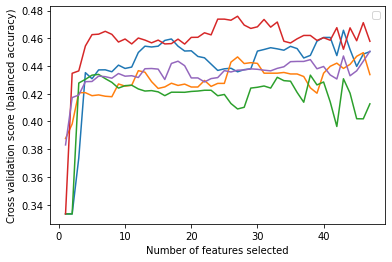

In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (balanced accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.legend()
plt.show()

In [59]:
print(rfecv.feature_names_in_[rfecv.support_])
print(len(rfecv.feature_names_in_[rfecv.support_]))
selected_features = rfecv.feature_names_in_[rfecv.support_]

['Day' 'Month' 'Year' 'HomeTeam_Enc' 'AwayTeam_Enc'
 'AwayStanding_PrevSeason' 'DiffStanding_PrevSeason' 'FTHG_HISTORY'
 'HTHG_HISTORY' 'HS_HISTORY' 'HST_HISTORY' 'HF_HISTORY' 'HC_HISTORY'
 'HY_HISTORY' 'HR_HISTORY' 'FTAG_HISTORY' 'HTAG_HISTORY' 'AS_HISTORY'
 'AST_HISTORY' 'AF_HISTORY' 'AC_HISTORY' 'AY_HISTORY' 'AR_HISTORY'
 'FTHG_AVG' 'HTHG_AVG' 'HS_AVG' 'HST_AVG' 'HF_AVG' 'HC_AVG' 'HY_AVG'
 'HR_AVG' 'FTAG_AVG' 'HTAG_AVG' 'AS_AVG' 'AST_AVG' 'AF_AVG' 'AC_AVG'
 'AY_AVG' 'AR_AVG' 'HW_AVG' 'AW_AVG' 'Ex_Goals_Home' 'Ex_Goals_Away']
43


## using select from model (L1-based feature selection)

In [29]:
df_epl2 = df_epl.copy()
#print(df_epl2.columns)

X = df_epl2.drop(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG','HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY','HR', 'AR','FTR_Enc','HTR_Enc'], axis=1)  #independent columns
y = df_epl2.loc[:,"FTR_Enc"]


lsvc = LinearSVC(C=0.01, penalty="l1", multi_class= "ovr", dual=False, max_iter=1200000).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
model.fit(X,y)




SelectFromModel(estimator=LinearSVC(C=0.01, dual=False, max_iter=1200000,
                                    penalty='l1'),
                prefit=True)

In [46]:
print(model.feature_names_in_[model.get_support()])
print(len(model.feature_names_in_[model.get_support()]))
selected_features = model.feature_names_in_[model.get_support()]

['Day' 'Month' 'Year' 'HomeTeam_Enc' 'AwayTeam_Enc' 'Referee_Enc'
 'HomeStanding_PrevSeason' 'AwayStanding_PrevSeason'
 'DiffStanding_PrevSeason' 'FTHG_HISTORY' 'HST_HISTORY' 'HF_HISTORY'
 'HC_HISTORY' 'AS_HISTORY' 'AC_HISTORY' 'FTHG_AVG' 'HS_AVG' 'HST_AVG'
 'HF_AVG' 'HC_AVG' 'FTAG_AVG' 'AS_AVG' 'AST_AVG' 'AF_AVG' 'AC_AVG'
 'AY_AVG' 'AW_AVG' 'Home_Manager_Enc' 'Away_Manager_Enc']
29


### getting importance feature / score

[]

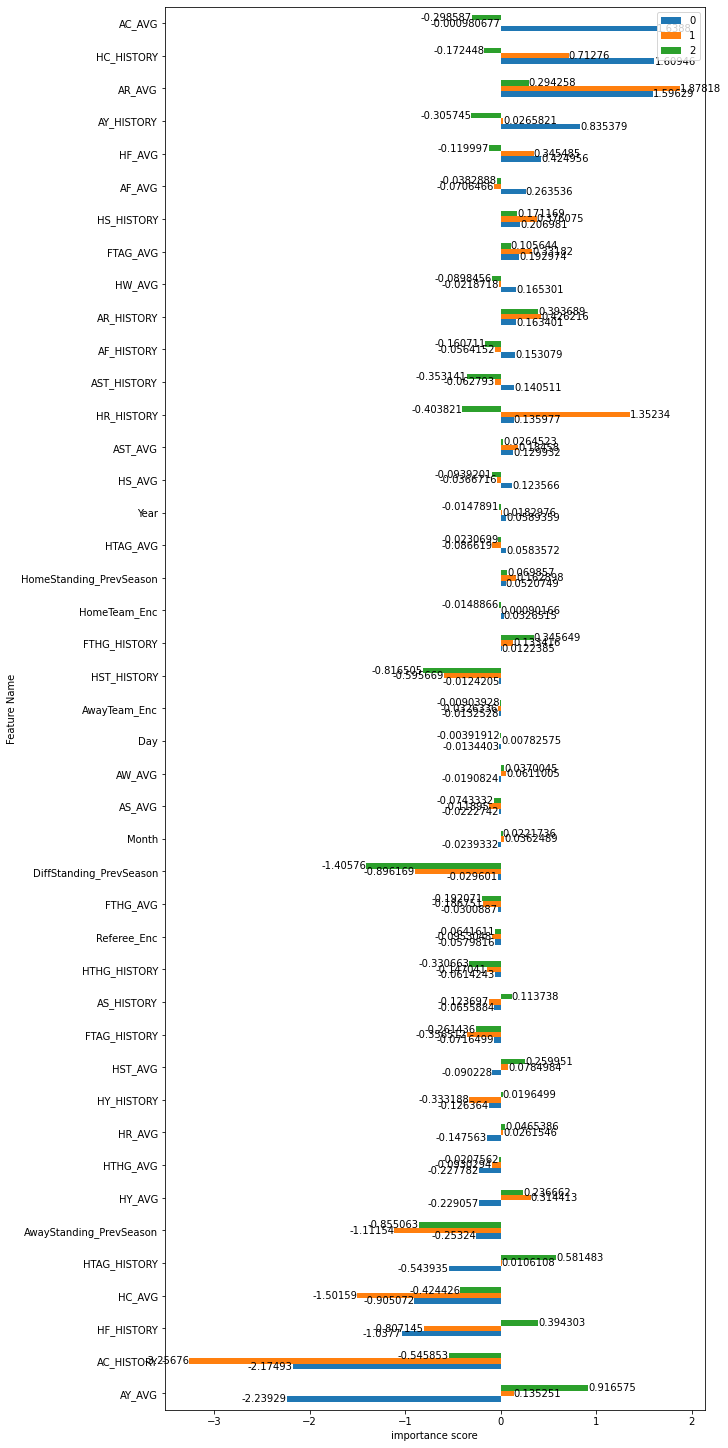

In [66]:
model=rfecv

try:
    #print(model)
    importance = model.estimator_.coef_
except:
    importance = model.estimator_.feature_importances_


# plot importances for all features
fig= plt.figure(figsize=(10,20), constrained_layout=True)
ax = fig.gca()
df = pd.DataFrame(importance).transpose()
df= df.rename(index=lambda s: model.feature_names_in_[s])

# sort
# print(df)
#df = df.mean(axis=1)
#print(df)
df = df.sort_values(0)
df.plot.barh(ax=ax,ylabel='Feature Name', xlabel='importance score')

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])
plt.plot()

# # plot importances for selected features
# fig= plt.figure(figsize=(10,20), constrained_layout=True)
# ax = fig.gca()
# df = pd.DataFrame(importance).transpose()
# df= df.rename(index=lambda s: model.feature_names_in_[s])


# df = df.filter(items=selected_features, axis=0)

# # sort
# # print(df)
# #df = df.mean(axis=1)
# print(df)
# df = df.sort_values(0)
# df.plot.barh(ax=ax,ylabel='Feature Name', xlabel='importance score')
# plt.plot()




### Tree based Model

In [62]:
df_epl2 = df_epl.copy()
#print(df_epl2.columns)

X = df_epl2.drop(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG','HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY','HR', 'AR','FTR_Enc','HTR_Enc'], axis=1)  #independent columns
y = df_epl2.loc[:,"FTR_Enc"]

clf = RandomForestClassifier()
clf = clf.fit(X, y)

model = SelectFromModel(clf, prefit=True)
model.fit(X,y)


SelectFromModel(estimator=RandomForestClassifier(), prefit=True)

In [63]:
print(model.feature_names_in_[model.get_support()])
print(len(model.feature_names_in_[model.get_support()]))
selected_features = model.feature_names_in_[model.get_support()]

['AwayStanding_PrevSeason' 'DiffStanding_PrevSeason' 'FTHG_HISTORY'
 'HTHG_HISTORY' 'HS_HISTORY' 'HST_HISTORY' 'HC_HISTORY' 'HY_HISTORY'
 'FTAG_HISTORY' 'HTAG_HISTORY' 'AS_HISTORY' 'AST_HISTORY' 'AC_HISTORY'
 'AR_HISTORY' 'HS_AVG' 'HST_AVG' 'HF_AVG' 'HC_AVG' 'FTAG_AVG' 'AS_AVG'
 'AST_AVG' 'AF_AVG' 'AC_AVG' 'AY_AVG' 'Ex_Goals_Home' 'Ex_Goals_Away']
26


         0         1         2         3         4         5        6   \
0  0.000798  0.000143  0.000022  0.001375 -0.001675 -0.000401  0.00000   
1  0.001337  0.002739 -0.000177 -0.001051 -0.000318  0.000624  0.00539   
2 -0.002192 -0.003648 -0.000366  0.000000  0.001932 -0.000249  0.00000   

         7         8         9   ...        37        38        39   40   41  \
0 -0.008471  0.016755  0.000000  ... -0.006154  0.008296  0.000000  0.0  0.0   
1  0.000000  0.000000  0.000000  ... -0.000522  0.000000 -0.011535  0.0  0.0   
2  0.002849 -0.021889  0.050957  ...  0.009504 -0.010807  0.000000  0.0  0.0   

       42   43   44        45        46  
0  0.0342  0.0  0.0 -0.000163 -0.000147  
1  0.0000  0.0  0.0  0.000103  0.000020  
2  0.0000  0.0  0.0  0.000104  0.000129  

[3 rows x 47 columns]


[]

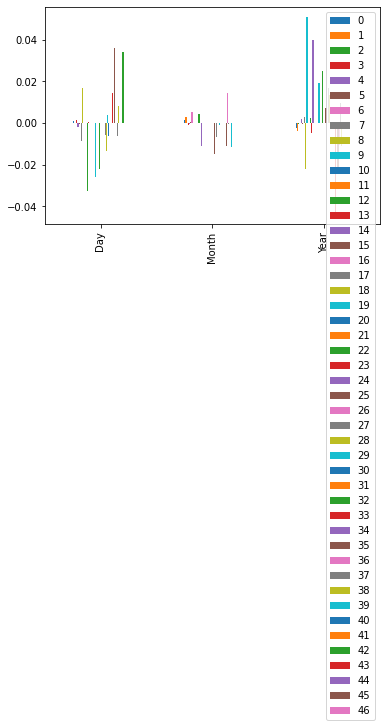

In [65]:
try:
    #print(model)
    importance = clf.coef_
except:
    pass
    #importance = clf.feature_importances_

print(pd.DataFrame(importance))

fig= plt.Figure()
ax = fig.gca()

df = pd.DataFrame(importance)
df= df.rename(index=lambda s: model.feature_names_in_[s])
df.plot.bar()

plt.plot()

### Sequential Feature Selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier


df_epl2 = df_epl.copy()
#print(df_epl2.columns)

X = df_epl2.drop(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG','HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY','HR', 'AR','FTR_Enc','HTR_Enc'], axis=1)  #independent columns
y = df_epl2.loc[:,"FTR_Enc"]

#clf = RandomForestClassifier()
#clf = clf.fit(X, y)

clf = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(estimator=clf,
    n_features_to_select="auto",
    cv=cv,
    scoring=scoring[refit],
    n_jobs=-1,
    )
sfs.fit(X, y)


NameError: name 'cv' is not defined

In [ ]:
print(sfs.feature_names_in_[sfs.get_support()])
print(len(sfs.feature_names_in_[sfs.get_support()]))
selected_features = sfs.feature_names_in_[sfs.get_support()]

['AwayStanding_PrevSeason' 'FTHG_HISTORY' 'HTHG_HISTORY' 'HF_HISTORY'
 'HC_HISTORY' 'HY_HISTORY' 'HR_HISTORY' 'FTAG_HISTORY' 'HTAG_HISTORY'
 'AS_HISTORY' 'AF_HISTORY' 'AC_HISTORY' 'AR_HISTORY' 'HTHG_AVG' 'HR_AVG'
 'HTAG_AVG' 'AC_AVG' 'AY_AVG' 'AR_AVG' 'HW_AVG' 'AW_AVG' 'Ex_Goals_Home'
 'Ex_Goals_Away']
23


## Model Selection & Cross Validation

### Auxiliary Functions - Classifier Evaluation

In [ ]:
def evaluate_report(y_pred, y_test):
  print("Balanced Accuracy: ", balanced_accuracy_score(y_test, y_pred))
  print("Accurary: ", accuracy_score(y_test,y_pred))
  # handle f1 score zero division
  # https://stackoverflow.com/questions/62326735/metrics-f1-warning-zero-division
  print(classification_report(y_test, y_pred, zero_division=0))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
# Used for summary part of each feature Set
model_acc_dict = {
  'RG': 0,
  'DT': 0,
  'RF': 0,
  'KNN': 0,
  'SVM': 0,
  'XGB': 0,
  'NN': 0
}

In [ ]:
def summary_hist(model_acc_dict=model_acc_dict, title="Summary of Models - Feature Set 1", fig_size=(9, 9)):
  model_names = model_acc_dict.keys()
  model_names = ["Random Guess", "Decision Tree", 
                  "Random Forest", "K Nearest Neighbors",
                  "Support Vector Machine", "XGB",
                  "Nerual Network"]
  
  x_label = "Accuracy (%)"
  y_label = "Models trained"

  accs = model_acc_dict.values()

  fig = plt.figure(figsize=fig_size)
  ax = fig.gca()
  p1 = ax.barh(model_names, accs)

  ax.set_title(title, fontsize=12)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

  for i, v in enumerate(accs):
      ax.text(v//2, i, str(v), color='white', fontsize=9, ha='left', va='center')

  fig.tight_layout()
  plt.show()

OPTIMIZATION & Cross Validation (TODO: Check content with others)
For every Feature set, we try the following classifiers:
  Decision Tree
  Random Forest
  K-Nearest Neighbours (KNN)
  Support Vector Machine
  XGBOOST [NOT IN NOTEBOOK YET]
  NN [NOT IN NOTEBOOK YET]
Linear Regreesion (Only used when prdicting the result goals)

In [ ]:
'''
Function used to plot changes on training loss & cross validation loss
'''
def plot_train_test_acc(results , scoring, param_x = "param_max_depth",title="GridSearchCV evaluation", xlabel="max_depth", ylabel="Score",xlim=(0,100), ylim=(0.4,1), fig_size=(9, 9)):

    # REF:https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
    plt.figure(figsize=fig_size)
    plt.title(title, fontsize=16)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    ax = plt.gca()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results[param_x].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ["g", "k"]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]
            ax.fill_between(
                X_axis,
                sample_score_mean - sample_score_std,
                sample_score_mean + sample_score_std,
                alpha=0.1 if sample == "test" else 0,
                color=color,
            )
            # change label(test) -> cross validation to avoid confusion
            if sample == "test":
              sample = "cross validation"
            ax.plot(
                X_axis,
                sample_score_mean,
                style,
                color=color,
                alpha=1 if sample == "cross validation" else 0.7,
                label="%s (%s)" % (scorer, sample),
            )

        best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
        best_score = results["mean_test_%s" % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot(
            [
                X_axis[best_index],
            ]
            * 2,
            [0, best_score],
            linestyle="-.",
            color=color,
            marker="x",
            markeredgewidth=3,
            ms=8,
        )
    
        # Annotate the best score for that scorer
        ax.annotate("%0.4f" % best_score, (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

In [ ]:
# """
# NOTE: Scoring metrics
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# """
# scoring = {"Accuracy": "accuracy", "Balanced_accuracy": "balanced_accuracy"}
# refit = "Balanced_accuracy"
# cv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [44]:
"""Decision Tree"""
def fit_DT(X, y):
    """ Parameters can be tweaked for regularization (more options see sklearn documentation)
    {'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'random_state': None,
    'splitter': 'best'}
    """
 
    classifier = DecisionTreeClassifier(random_state=42)
    print(list(np.linspace(1, X.shape[1], X.shape[1]//5, dtype=int)))
    param_grid = {'max_depth': list(np.linspace(1, X.shape[1], X.shape[1]//5, dtype=int)),
                  'max_features': list(np.linspace(1, X.shape[1], X.shape[1]//5, dtype=int))}
    # NOTE: more option eg. custom scoring metric avaliable -> see sklearn doc
    # n_jobs used for optimization (use all processor)
    # verbose -> display detail (0,1,>1) higher -> more detailed
    grid = GridSearchCV(
        classifier, 
        param_grid=param_grid, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1, 
        scoring=scoring, 
        return_train_score=True,
        refit=refit)
    clf = grid.fit(X, y)

    return clf

In [ ]:
def fit_RF(X, y):
    """ Parameters can be tweaked for regularization (more options see sklearn documentation)
    {'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 100,
    'n_jobs': None,
    'oob_score': False,
    'random_state': None,
    'verbose': 0,
    'warm_start': False}
    """
    
    classifier = RandomForestClassifier(random_state=42)
    param_grid = {'max_depth':list(np.linspace(1, X.shape[1], X.shape[1]//5, dtype=int)),
                  'max_features': list(np.linspace(1, X.shape[1], X.shape[1]//5, dtype=int))}
    # NOTE: more option eg. custom scoring metric avaliable -> see sklearn doc
    # n_jobs used for optimization (use all processor)
    # verbose -> display detail (0,1,>1) higher -> more detailed
    grid = GridSearchCV(
        classifier, 
        param_grid=param_grid, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1, 
        scoring=scoring, 
        return_train_score=True,
        refit=refit)
    clf = grid.fit(X, y)

    return clf

In [ ]:
def fit_KNN(X, y):
    """ Parameters can be tweaked for regularization (more options see sklearn documentation)
    {'algorithm': 'auto',
    'leaf_size': 30,
    'metric': 'minkowski',
    'metric_params': None,
    'n_jobs': None,
    'n_neighbors': 5,
    'p': 2,
    'weights': 'uniform'}
    """
    classifier = KNeighborsClassifier()
    # Only tweaked the depth here as an example
    param_grid = {'n_neighbors':list(np.linspace(start=3, stop=100, num=50, dtype=int))}
    # NOTE: more option eg. custom scoring metric avaliable -> see sklearn doc
    # n_jobs used for optimization (use all processor)
    # verbose -> display detail (0,1,>1) higher -> more detailed
    grid = GridSearchCV(
        classifier, 
        param_grid=param_grid, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1, 
        scoring=scoring, 
        return_train_score=True,
        refit=refit)
    clf = grid.fit(X, y)

    return clf

In [ ]:
def fit_SVM(X, y):
    """ Parameters can be tweaked for regularization (more options see sklearn documentation)
    {'C': 1.0,
    'break_ties': False,
    'cache_size': 200,
    'class_weight': None,
    'coef0': 0.0,
    'decision_function_shape': 'ovr',
    'degree': 3,
    'gamma': 'scale',
    'kernel': 'rbf',
    'max_iter': -1,
    'probability': False,
    'random_state': None,
    'shrinking': True,
    'tol': 0.001,
    'verbose': False}
    """
    classifier = svm.SVC()
    # Only tweaked the depth here as an example
    param_grid = {'C':[1.0,5.0,10.0,15.0, 20.0, 25.0, 30.0]
                  }
    # NOTE: more option eg. custom scoring metric avaliable -> see sklearn doc
    # n_jobs used for optimization (use all processor)
    # verbose -> display detail (0,1,>1) higher -> more detailed
    grid = GridSearchCV(
        classifier, 
        param_grid=param_grid, 
        cv=cv, 
        verbose=1, 
        n_jobs=-1, 
        scoring=scoring, 
        return_train_score=True,
        refit=refit)
    clf = grid.fit(X, y)

    return clf

## TEST NOW

In [ ]:
def create_df(df_epl):
  return df_epl.copy()

def create_design_matrix(df):
  X = df.loc[:, selected_features].values
  return X

df_final = create_df(df_epl)
X = create_design_matrix(df_final)
y = df_final.loc[:,['FTR']].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, shuffle=False)

FTR_encoder = LabelEncoder()
y_train = FTR_encoder.fit_transform(y_train);

/home/adamliu/anaconda3/envs/COMP0036/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Random Forest

In [ ]:
# Fit the model using training data
clf = fit_RF(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


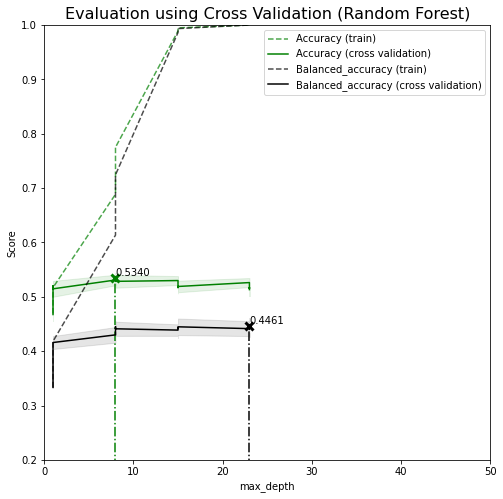

In [ ]:
plot_train_test_acc(results, scoring, title="Evaluation using Cross Validation (Random Forest)", xlabel="max_depth", ylabel="Score", fig_size=(8,8), xlim=(0,50), ylim=(0.2,1.0))

Balanced Accuracy:  0.45053782718004953
Accurary:  0.5099247091033539
              precision    recall  f1-score   support

           A       0.53      0.47      0.50       491
           D       0.30      0.16      0.21       328
           H       0.54      0.72      0.62       642

    accuracy                           0.51      1461
   macro avg       0.46      0.45      0.44      1461
weighted avg       0.49      0.51      0.49      1461



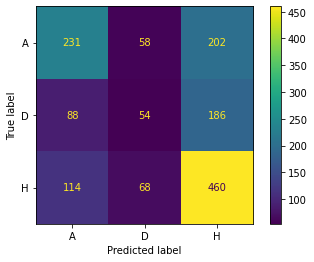

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['RF'] = round(accuracy_score(y_test,y_pred)*100, 2)

### SVM

In [ ]:
clf = fit_SVM(X_train, y_train)
results = clf.cv_results_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


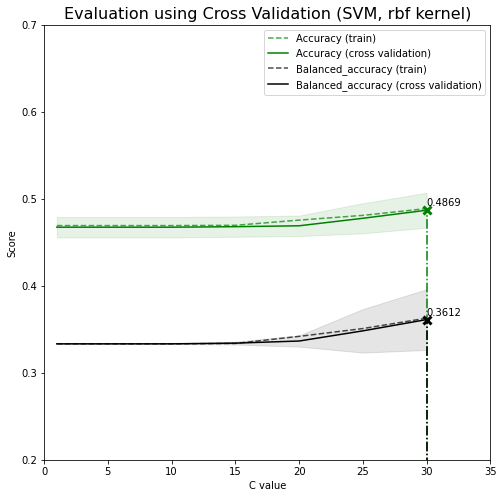

In [ ]:
plot_train_test_acc(results, scoring,param_x="param_C", title="Evaluation using Cross Validation (SVM, rbf kernel)", xlabel="C value", ylabel="Score", fig_size=(8,8), xlim=(0,35), ylim=(0.2,0.7))

Balanced Accuracy:  0.42186353321362935
Accurary:  0.5167693360711841
              precision    recall  f1-score   support

           A       0.56      0.38      0.45       491
           D       0.00      0.00      0.00       328
           H       0.50      0.88      0.64       642

    accuracy                           0.52      1461
   macro avg       0.36      0.42      0.37      1461
weighted avg       0.41      0.52      0.43      1461



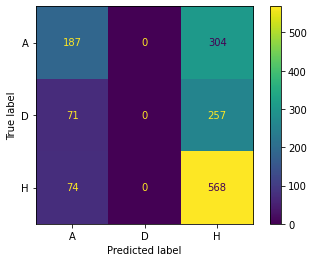

In [ ]:
best_clf = clf.best_estimator_
# Make predictions using the model we have created
y_pred = best_clf.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
y_pred = FTR_encoder.inverse_transform(y_pred)

evaluate_report(y_pred, y_test)
model_acc_dict['SVM'] = round(accuracy_score(y_test,y_pred)*100, 2)